In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
from pandas import datetime
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset

In [2]:
df = pd.read_csv('E://DS/BHN/GC_Traffic.txt', sep='\t')
df.Date = df.Date.apply(lambda x: x.split()[0]).apply(lambda x: datetime.strptime(x,'%d/%m/%y'))
df.columns = ['Date', 'Sales']
df.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
Date,2016-01-01 00:00:00,2016-01-02 00:00:00,2016-01-03 00:00:00,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-09 00:00:00,2016-01-10 00:00:00
Sales,2093576,2397260,2173039,2051240,1954117,1923592,1927622,2074300,2121106,1802039


In [3]:
df.set_index('Date', inplace=True)
df.head(10).transpose()

Date,2016-01-01 00:00:00,2016-01-02 00:00:00,2016-01-03 00:00:00,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-09 00:00:00,2016-01-10 00:00:00
Sales,2093576,2397260,2173039,2051240,1954117,1923592,1927622,2074300,2121106,1802039


#### Data Scaling

- Selective Scaling

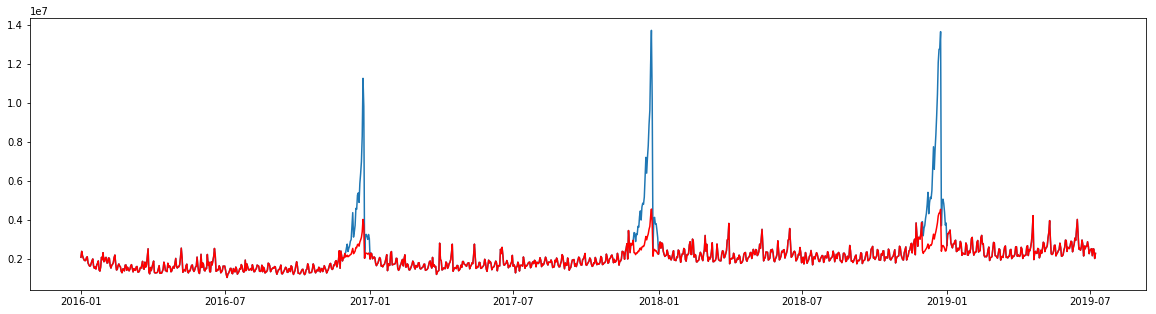

In [4]:
df5 = df.copy()

x_min = df5[(df5.index.year==2016) & (df5.index.month==12)].min()[0]
ratio = (df5[(df5.index.year==2016) & (df5.index.month==11)].max()/df5[(df5.index.year==2016) & (df5.index.month==12)].max())[0]

def scale(x,i):
    x = x - x_min
    if i < 0:
        x = x * ratio
    else:
        x = x / ratio
    x = x + x_min
    return x

df5.Sales[df5.index.month==12] = df5.Sales[df5.index.month==12].apply(lambda x: scale(x,-1)) # Down Scaling Data

plt.figure(figsize=(20,5))
plt.plot(df)
plt.plot(df5, color='red')
plt.show()

- Feature Scaling

In [5]:
# Find Upper Bound
max_16 = df[df.index.year==2016].max()
max_17 = df[df.index.year==2017].max()
max_18 = df[df.index.year==2018].max()

diff_16_17 = abs(max_16 - max_17)
diff_17_18 = abs(max_17 - max_18)

diff_18_19 = (diff_16_17 + diff_17_18)/2
UB = max_19 = max_18 + diff_18_19

# Find Lower Bound
LB = min_16_17_18_19 = df.min()

print('Lower Bound = ',LB.values[0], '\nUpper Bound = ', UB.values[0])


Lower Bound =  1061345 
Upper Bound =  14910388.5


        count     mean       std  min       25%       50%       75%       max
Sales  1285.0  0.06582  0.035026  0.0  0.039652  0.061638  0.084713  0.234891


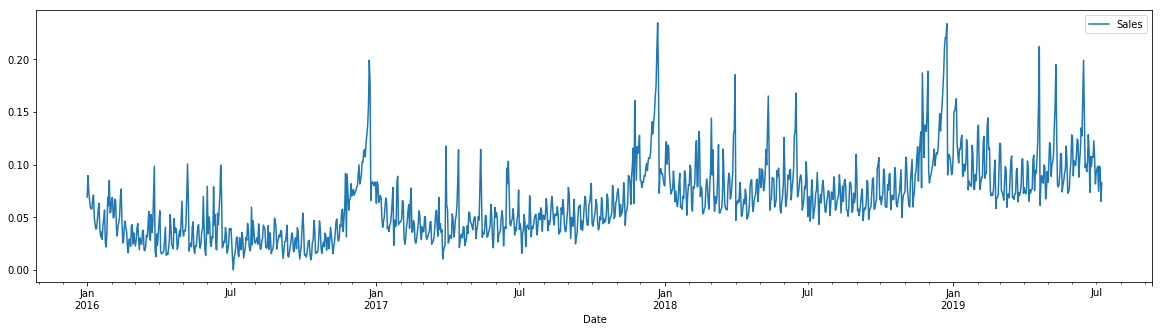

In [6]:
df5.Sales = df5.Sales.apply(lambda x: (x-LB)/UB)
print(df5.describe().transpose())
df5.plot(figsize=(20,5))
plt.show()

### Data Transformation (From Time-Series to Supervised)

In [7]:
df6 = df5.copy()

df6['year' ] = df6.index.year
df6.year = df6.year.apply(lambda x: int(x))

df6['month' ] = df6.index.month
df6.month = df6.month.apply(lambda x: int(x))

df6['date' ] = df6.index.date
df6.date = df6.date.apply(lambda x: int(str(x).split('-')[2]))

df6.reset_index(inplace=True)

df6 = df6.iloc[:,1:]

df6.head()

,Sales,year,month,date
0,0.069229,2016,1,1
1,0.089596,2016,1,2
2,0.074558,2016,1,3
3,0.066390,2016,1,4
4,0.059876,2016,1,5


In [8]:
index_2017 = df6.query('year==2017 and month==1 and date==1').index[0] # Leap-Year 2016
index_2018 = df6.query('year==2018 and month==1 and date==1').index[0]
index_2019 = df6.query('year==2019 and month==1 and date==1').index[0]

print('Indexes are :', index_2017, index_2018, index_2019)

Indexes are : 366 731 1096


In [9]:
df6.year  = df6.year/df6.year.max()
df6.month = df6.month/df6.month.max()
df6.date  = df6.date/df6.date.max()

df6.head()

,Sales,year,month,date
0,0.069229,0.998514,0.083333,0.032258
1,0.089596,0.998514,0.083333,0.064516
2,0.074558,0.998514,0.083333,0.096774
3,0.066390,0.998514,0.083333,0.129032
4,0.059876,0.998514,0.083333,0.161290


In [10]:
# Create Data for Supervised Learning

def prepare_data(dfs, starting_index, lags):
    
    sl_df = pd.DataFrame()    
    for i in range(starting_index,df.shape[0]):              
        a = pd.Series([dfs.Sales[i], dfs.date[i], dfs.month[i], dfs.year[i]])
        b = pd.Series(dfs.Sales[i-lags:i].values)
        c = a.append(b, ignore_index = True)    
        sl_df = sl_df.append(c, ignore_index=True)

    sl_df.columns = ['target', 'date', 'month', 'year']+['D'+str(i+1) for i in range(lags)]    
    return sl_df



def define_window(window='annually', days=365):
    if window=='annually':
        return index_2017, 365
    elif window=='semi-annually':
        return 183, 182          # 183 due to Leap year - 2016
    elif window=='monthly':        
        return 31, 30
    elif window=='weekly':
        return 7, 7
    else:
        return days, days
        

starting_index, lag_days = define_window('annually', 10)
sl_df = prepare_data(df6, starting_index, lag_days)
sl_df.date, sl_df.month, sl_df.year = sl_df.date.apply(lambda x: int(x)), sl_df.month.apply(lambda x: int(x)), sl_df.year.apply(lambda x: int(x))        

sl_df.head(3)

,target,date,month,year,D1,D2,D3,D4,D5,D6,...,D356,D357,D358,D359,D360,D361,D362,D363,D364,D365
0,0.063140,0,0,0,0.089596,0.074558,0.066390,0.059876,0.057829,0.058099,...,0.156464,0.199335,0.178498,0.066009,0.082379,0.083691,0.082084,0.079969,0.083606,0.080549
1,0.083658,0,0,0,0.074558,0.066390,0.059876,0.057829,0.058099,0.067936,...,0.199335,0.178498,0.066009,0.082379,0.083691,0.082084,0.079969,0.083606,0.080549,0.063140
2,0.081396,0,0,0,0.066390,0.059876,0.057829,0.058099,0.067936,0.071075,...,0.178498,0.066009,0.082379,0.083691,0.082084,0.079969,0.083606,0.080549,0.063140,0.083658


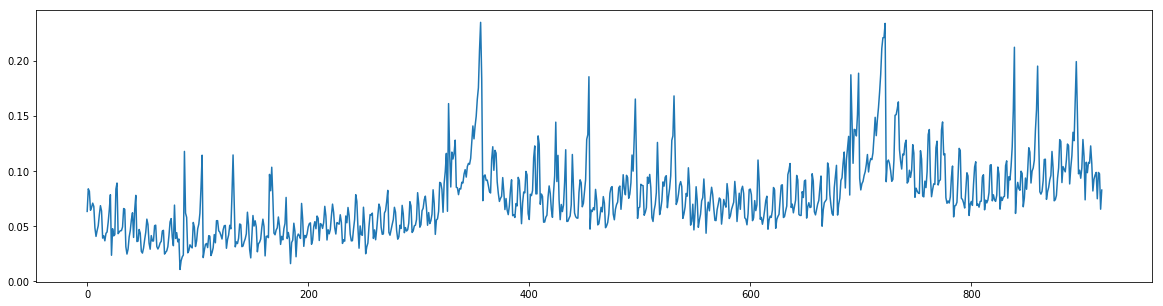

In [11]:
sl_df.target.plot(figsize=(20,5))
plt.show()

### Parameter Tuning

- Train Test Data Split

In [12]:
from sklearn.model_selection import train_test_split
X, y = sl_df.iloc[:,1:], sl_df.iloc[:,0:1]
print('X-y dimension = ', X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print('Dimension',
      '\nX train =',X_train.shape, 
      '\nX_test  =',X_test.shape , 
      '\ny_train =',y_train.shape, 
      '\ny_test  =',y_test.shape)

X-y dimension =  (919, 368) (919, 1)
Dimension 
X train = (735, 368) 
X_test  = (184, 368) 
y_train = (735, 1) 
y_test  = (184, 1)


- Metric Definition

In [13]:
def get_score(actual, predict, metric=4):    
    if metric == 1: 
        return abs(actual - predict).mean()               # Mean Absolute Error
    if metric == 2: 
        return ((actual - predict)**2).mean()             # Mean Squared Error
    if metric == 3: 
        return np.sqrt(((actual - predict)**2).mean())    # Root Mean Squared Error
    if metric == 4: 
        return abs((actual - predict)/actual*100).mean()  # Mean Absolute Percentage Error (Good for Relative Comparison)

## Multi-Layer Perceptron

In [14]:
from sklearn.neural_network import MLPRegressor
MLP_REG = MLPRegressor(random_state=1, max_iter=500)
MLP_REG.fit(X, y)
y_pred = MLP_REG.predict(X)

y_pred[:10].transpose()

D:\anaconda_install\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.08377186, 0.08498964, 0.09174513, 0.09110423, 0.0797286 ,
       0.08931751, 0.08389081, 0.07507031, 0.07239514, 0.08638516])

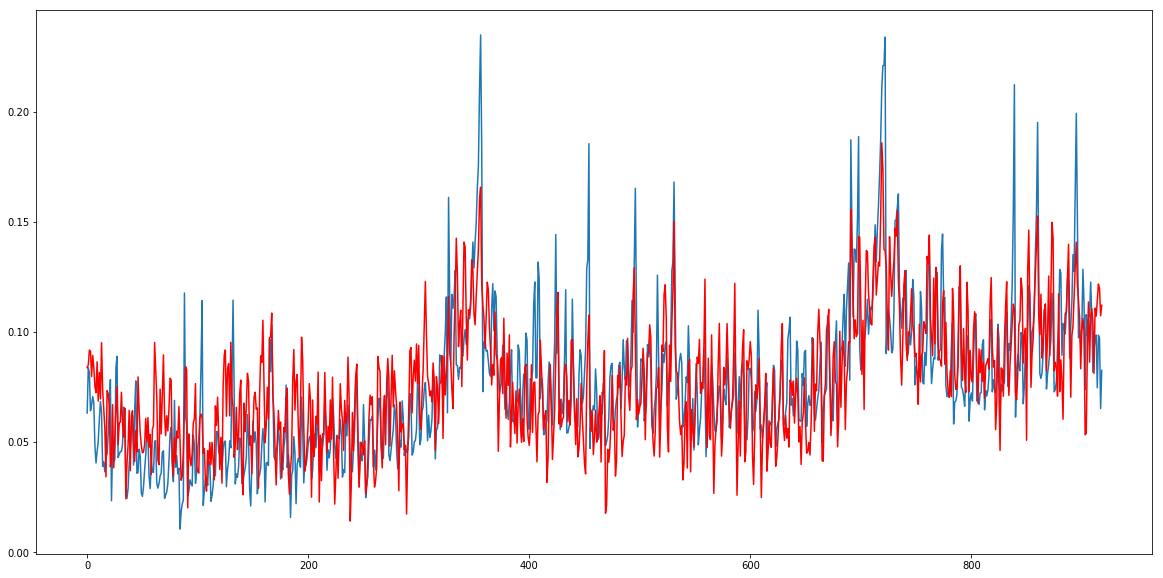

In [25]:
plt.figure(figsize=(20,10))
plt.plot(y.values)
plt.plot(y_pred, color='red')
plt.show()

In [37]:
def get_df(y_pred):
    df7 = df.copy()
    df7 = df7[df.index.year>2016]
    df7['predict'] = y_pred

    df7['Date'] = df[df.index.year>2016].index
    df7.set_index('Date', inplace=True)

    df7.predict = df7.predict.apply(lambda x: x*UB + LB)
    df7.predict[df7.index.month==12] = df7.predict[df7.index.month==12].apply(lambda x: scale(x, 1))
    
    return df7


def plot_prediction(temp_df):
    
    MAPE = get_score(temp_df.Sales, temp_df.predict, metric=4)
    print('The performance of Multilayer Perceptron = ', MAPE, '%')
    
    temp_df[['Sales','predict']].plot(figsize=(20,7))
    plt.show()
    

The performance of Multilayer Perceptron =  13.655583472031433 %


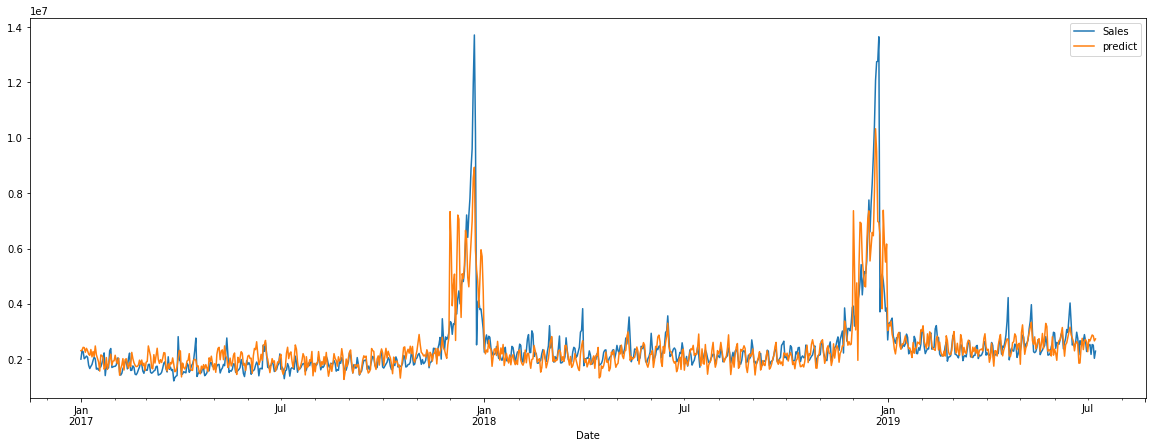

In [38]:
temp_df = get_df(y_pred)
plot_prediction(temp_df)

In [36]:
print(MLP_REG)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=500,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)


#### Improve Multi-layer Perceptron

D:\anaconda_install\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The performance of Multilayer Perceptron =  13.655583472031433 %


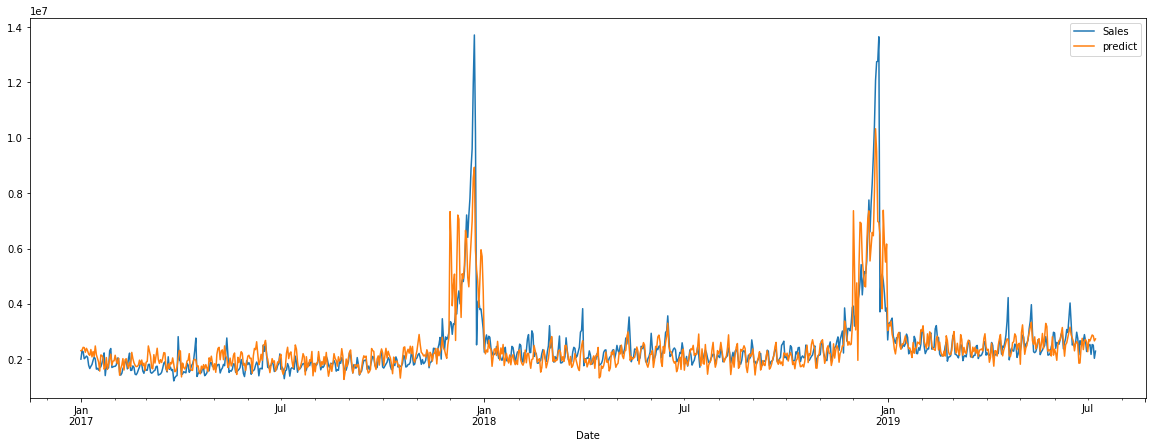

In [46]:
from sklearn.neural_network import MLPRegressor
MLP_REG2= MLPRegressor(random_state=1, max_iter=500)
#hidden_layer_sizes=(365,2), max_iter=500, n_iter_no_change=10, momentum=0.9,  
 #                      learning_rate_init=0.001, learning_rate='adaptive', solver='adam',
  #                     validation_fraction=0.1, shuffle=False, random_state=1, warm_start=True)
MLP_REG2.fit(X, y)
y_pred = MLP_REG2.predict(X)

temp_df = get_df(y_pred)
plot_prediction(temp_df)

D:\anaconda_install\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The performance of Multilayer Perceptron =  9.620698869874273 %


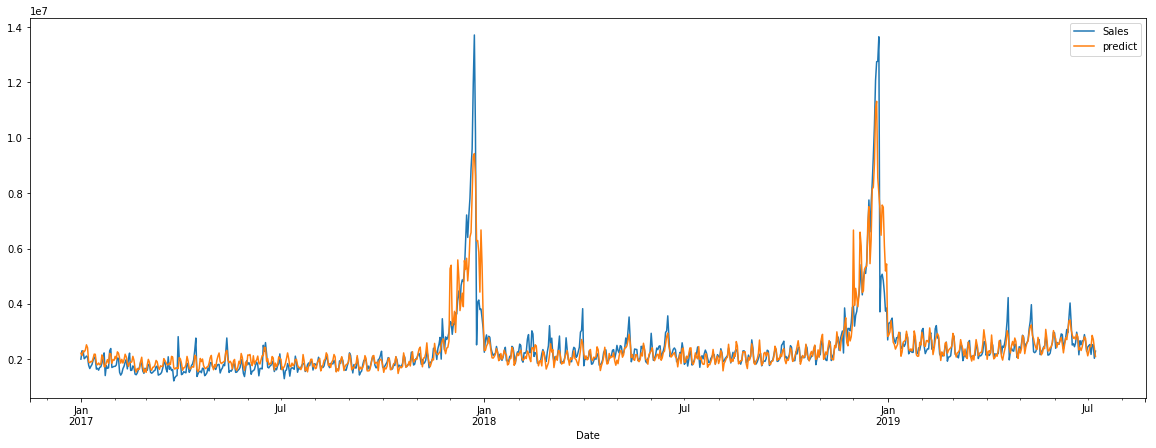

In [70]:
from sklearn.neural_network import MLPRegressor
MLP_REG2= MLPRegressor(random_state=1, max_iter=500,hidden_layer_sizes=(500,4))
#hidden_layer_sizes=(365,2), max_iter=500, n_iter_no_change=10, momentum=0.9,  
 #                      learning_rate_init=0.001, learning_rate='adaptive', solver='adam',
  #                     validation_fraction=0.1, shuffle=False, random_state=1, warm_start=True)
MLP_REG2.fit(X, y)
y_pred = MLP_REG2.predict(X)

temp_df = get_df(y_pred)
plot_prediction(temp_df)

D:\anaconda_install\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The performance of Multilayer Perceptron =  9.596045737801232 %


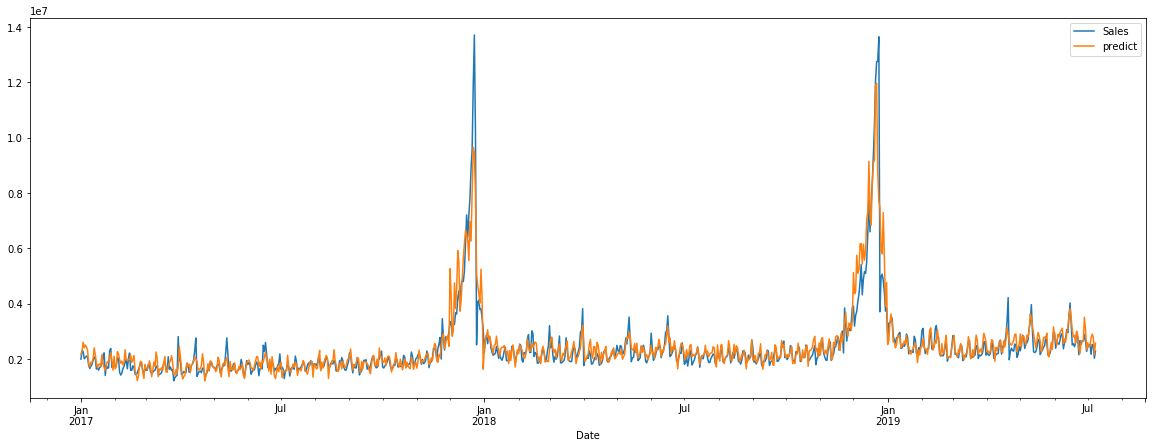

In [76]:
from sklearn.neural_network import MLPRegressor
MLP_REG2= MLPRegressor(random_state=1, max_iter=500,hidden_layer_sizes=(1000,3))
#hidden_layer_sizes=(365,2), max_iter=500, n_iter_no_change=10, momentum=0.9,  
 #                      learning_rate_init=0.001, learning_rate='adaptive', solver='adam',
  #                     validation_fraction=0.1, shuffle=False, random_state=1, warm_start=True)
MLP_REG2.fit(X, y)
y_pred = MLP_REG2.predict(X)

temp_df = get_df(y_pred)
plot_prediction(temp_df)

### Future Predictions